In [38]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from PIL import Image

In [24]:
excel_file="data.xlsx"

In [25]:
data = pd.read_excel(excel_file, sheet_name=None)
peach_data = data["Peach"]

In [26]:
peach_data_top = peach_data[["File name", "% Waste"]]
peach_data_top.dropna(inplace=True)

peach_data_side = peach_data[["File name.1", "% Waste.1"]]

peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
peach_data_side.dropna(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_13284\4094097339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peach_data_top.dropna(inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13284\4094097339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13284\4094097339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [27]:
peach_data_top

,File name,% Waste
0,20230718_peach_01_top_01,6.211873
1,20230718_peach_02_top_01,26.893904
2,20230719_peach_01_top_01,4.288291
3,20230719_peach_02_top_01,4.424803
4,20230719_peach_03_top_01,6.132037
...,...,...
120,20231013_peach_12_top_01,6.210898
121,20231013_peach_13_top_01,22.820151
122,20231013_peach_14_top_01,20.298928
123,20231013_peach_15_top_01,23.863501


In [28]:
peach_data_side

,File name,% Waste
0,20230718_peach_01_side_01,6.211873
1,20230718_peach_02_side_01,26.893904
2,20230719_peach_01_side_01,4.288291
3,20230719_peach_02_side_01,4.424803
4,20230719_peach_03_side_01,6.132037
...,...,...
125,20231013_peach_12_side_01,6.210898
126,20231013_peach_13_side_01,22.820151
127,20231013_peach_14_side_01,20.298928
128,20231013_peach_15_side_01,23.863501


In [29]:
data = pd.concat([peach_data_side,peach_data_top], axis=0)

In [30]:
data

,File name,% Waste
0,20230718_peach_01_side_01,6.211873
1,20230718_peach_02_side_01,26.893904
2,20230719_peach_01_side_01,4.288291
3,20230719_peach_02_side_01,4.424803
4,20230719_peach_03_side_01,6.132037
...,...,...
120,20231013_peach_12_top_01,6.210898
121,20231013_peach_13_top_01,22.820151
122,20231013_peach_14_top_01,20.298928
123,20231013_peach_15_top_01,23.863501


Extraction Color Histograms and Training Models

In [31]:
# Function to extract histogram features from image files
def extract_histogram(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise Exception(f"Failed to open image '{image_path}'")
        hist = cv2.calcHist(
            [image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]
        )
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    except Exception as e:
        print(f"Error processing image '{image_path}': {e}")
        return None


# Extracting histogram features from filenames
peach_folder = "cropped_peach"
data["Histogram"] = data["File name"].apply(
    lambda x: extract_histogram(os.path.join(peach_folder, x + ".jpg"))
)

# Remove rows where the histogram extraction failed
data = data.dropna()

# Preparing features and target
X = np.vstack(data["Histogram"]).astype(float)
y = data["% Waste"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Training regression models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}: RMSE = {rmse}")

Error processing image 'cropped_peach\20231006_peach_17_side_01.jpg': Failed to open image 'cropped_peach\20231006_peach_17_side_01.jpg'
Error processing image 'cropped_peach\20231004_peach_05_top_01.jpg': Failed to open image 'cropped_peach\20231004_peach_05_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_14_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_14_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_15_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_15_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_16_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_16_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_17_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_17_top_01.jpg'
Error processing image 'cropped_peach\20231011_peach_01_top_02.jpg': Failed to open image 'cropped_peach\20231011_peach_01_top_02.jpg'
Random Forest: RMSE = 9.431581179970365
XGBoost: RMSE

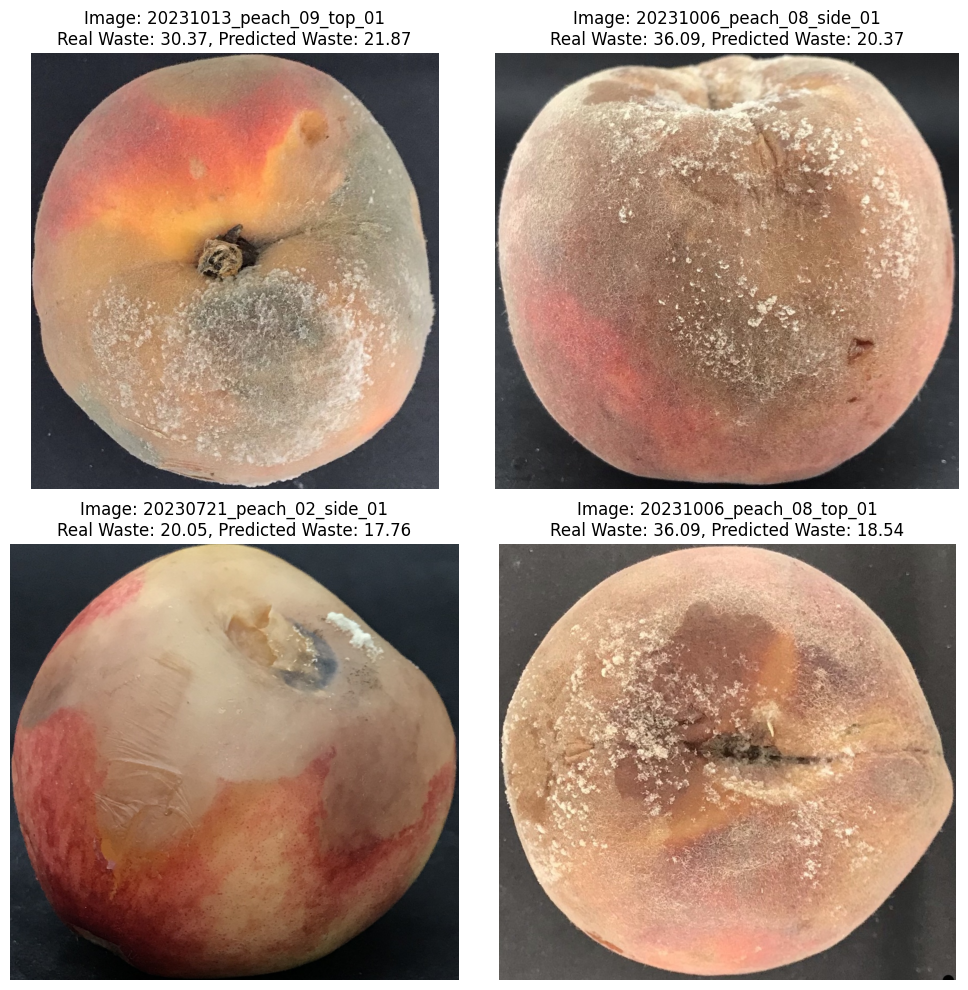

In [32]:

test_filenames = random.sample(
    data["File name"].tolist(), 4
)  # Select 4 images for a 2x2 grid
test_image_paths = [
    os.path.join(peach_folder, f"{filename}.jpg") for filename in test_filenames
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Display real and predicted waste percentages for test images
for ax, image_path, filename in zip(axes.flatten(), test_image_paths, test_filenames):
    real_waste_percentage = data[data["File name"] == filename]["% Waste"].values[0]
    hist = extract_histogram(image_path)
    if hist is not None:
        hist = hist.reshape(1, -1)
        predicted_waste = model.predict(hist)[0]

        # Load and display the image using Matplotlib
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(
            f"Image: {filename}\nReal Waste: {real_waste_percentage:.2f}, Predicted Waste: {predicted_waste:.2f}"
        )
        ax.axis("off")  # Hide axes
    else:
        print(f"Image: {image_path}, Histogram extraction failed")

# Adjust layout
plt.tight_layout()
plt.show()

## DL Based Regression

In [33]:
train_df, test_df = train_test_split(data.dropna(), test_size=0.2, random_state=42)

train_df = train_df[
    train_df["File name"].apply(
        lambda x: os.path.exists(os.path.join("cropped_peach", x + ".jpg"))
    )
]
test_df = test_df[
    test_df["File name"].apply(
        lambda x: os.path.exists(os.path.join("cropped_peach", x + ".jpg"))
    )
]


val_df, test_df = train_test_split(test_df,test_size=0.5, random_state=42)

len(train_df),len(test_df), len(val_df)

(198, 25, 25)

In [34]:
train_df

,File name,% Waste,Histogram
26,20230929_peach_01_top_01,14.966811,"[1.18400785e-05, 9.8667315e-06, 0.0, 0.0, 0.0,..."
88,20231009_peach_04_top_01,17.221499,"[0.043154318, 0.0443638, 0.0008869535, 0.00025..."
119,20231013_peach_07_side_01,27.725322,"[0.06984565, 0.00081177003, 0.0, 0.0, 0.0, 0.0..."
72,20231008_peach_01_top_01,6.609875,"[0.19472185, 0.009439321, 5.161233e-05, 0.0, 0..."
92,20231009_peach_08_top_01,4.499629,"[0.05675836, 0.021577159, 0.00034545563, 0.0, ..."
...,...,...,...
107,20231011_peach_05_side_01,10.715369,"[0.07478849, 0.019793935, 3.2070537e-05, 0.0, ..."
14,20230803_peach_03_side_01,7.155886,"[0.28346574, 6.2531735e-06, 3.1265868e-06, 0.0..."
93,20231009_peach_08_side_01,4.499629,"[0.58009815, 0.058217444, 3.8047066e-05, 0.0, ..."
50,20231004_peach_01_top_01,15.015108,"[0.3538273, 0.015404593, 0.0, 0.0, 0.0, 0.0, 0..."


In [40]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0] + ".jpg")
        if not os.path.exists(img_name):
            return None, None
        image = cv2.imread(img_name)
        label = self.dataframe.iloc[idx, 1]

        # Convert BGR image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


# Define image transformations
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)

# Define datasets and data loaders
train_dataset = CustomDataset(train_df, "cropped_peach", transform=transform)
test_dataset = CustomDataset(test_df, "cropped_peach", transform=transform)
val_dataset = CustomDataset(val_df, "cropped_peach", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Define the model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        resnet = torchvision.models.resnet34(pretrained=True)
        self.features = nn.Sequential(
            *list(resnet.children())[:-1]
        )  # Remove the last fully connected layer
        self.regressor = nn.Linear(
            512, 1
        )  # Replace the last layer with a regression layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x


# Define the model
model = RegressionModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=3, verbose=True
)

# Early stopping
best_val_loss = float("inf")
patience = 10
counter = 0

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False
    ):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs.squeeze(), labels.float())
        val_running_loss += val_loss.item() * inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_epoch_loss)

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        true_labels.extend(labels.tolist())

mse = mean_squared_error(true_labels, predictions)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.7MB/s]
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: Th

Epoch [1/100], Training Loss: 451.0866
Epoch [1/100], Validation Loss: 558.6583


Epoch [2/100], Training Loss: 300.4170
Epoch [2/100], Validation Loss: 330.6613


Epoch [3/100], Training Loss: 216.7753
Epoch [3/100], Validation Loss: 143.0113


Epoch [4/100], Training Loss: 171.3608
Epoch [4/100], Validation Loss: 167.3930


Epoch [5/100], Training Loss: 119.4753
Epoch [5/100], Validation Loss: 82.7758


Epoch [6/100], Training Loss: 99.5207
Epoch [6/100], Validation Loss: 101.1880


Epoch [7/100], Training Loss: 72.5630
Epoch [7/100], Validation Loss: 75.5280


Epoch [8/100], Training Loss: 70.9903
Epoch [8/100], Validation Loss: 67.1552


Epoch [9/100], Training Loss: 78.9158
Epoch [9/100], Validation Loss: 41.6965


Epoch [10/100], Training Loss: 46.3733
Epoch [10/100], Validation Loss: 64.3559


Epoch [11/100], Training Loss: 40.9835
Epoch [11/100], Validation Loss: 40.8210


Epoch [12/100], Training Loss: 48.4395
Epoch [12/100], Validation Loss: 25.1829


Epoch [13/100], Training Loss: 32.2729
Epoch [13/100], Validation Loss: 32.1172


Epoch [14/100], Training Loss: 33.3941
Epoch [14/100], Validation Loss: 28.8423


Epoch [15/100], Training Loss: 32.0397
Epoch [15/100], Validation Loss: 38.7281


Epoch [16/100], Training Loss: 20.0676
Epoch [16/100], Validation Loss: 30.7845


Epoch [17/100], Training Loss: 19.4392
Epoch [17/100], Validation Loss: 28.3410


Epoch [18/100], Training Loss: 18.5032
Epoch [18/100], Validation Loss: 25.3108


Epoch [19/100], Training Loss: 20.7633
Epoch [19/100], Validation Loss: 25.4969


Epoch [20/100], Training Loss: 9.5172
Epoch [20/100], Validation Loss: 24.6929


Epoch [21/100], Training Loss: 12.5432
Epoch [21/100], Validation Loss: 26.0805


Epoch [22/100], Training Loss: 21.0574
Epoch [22/100], Validation Loss: 24.9345


Epoch [23/100], Training Loss: 20.0617
Epoch [23/100], Validation Loss: 25.1782


Epoch [24/100], Training Loss: 7.4615
Epoch [24/100], Validation Loss: 23.9946


Epoch [25/100], Training Loss: 10.2385
Epoch [25/100], Validation Loss: 24.8373


Epoch [26/100], Training Loss: 8.7758
Epoch [26/100], Validation Loss: 25.1089


Epoch [27/100], Training Loss: 11.9946
Epoch [27/100], Validation Loss: 25.9705


Epoch [28/100], Training Loss: 16.4533
Epoch [28/100], Validation Loss: 25.9276


Epoch [29/100], Training Loss: 12.5214
Epoch [29/100], Validation Loss: 25.6369


Epoch [30/100], Training Loss: 11.7237
Epoch [30/100], Validation Loss: 25.9576


Epoch [31/100], Training Loss: 8.1458
Epoch [31/100], Validation Loss: 25.4144


Epoch [32/100], Training Loss: 10.9845
Epoch [32/100], Validation Loss: 25.5328


Epoch [33/100], Training Loss: 13.8414
Epoch [33/100], Validation Loss: 25.8636


Epoch [34/100], Training Loss: 16.9920
Epoch [34/100], Validation Loss: 25.4460
Early stopping...


Mean Squared Error on Test Set: 61.7966


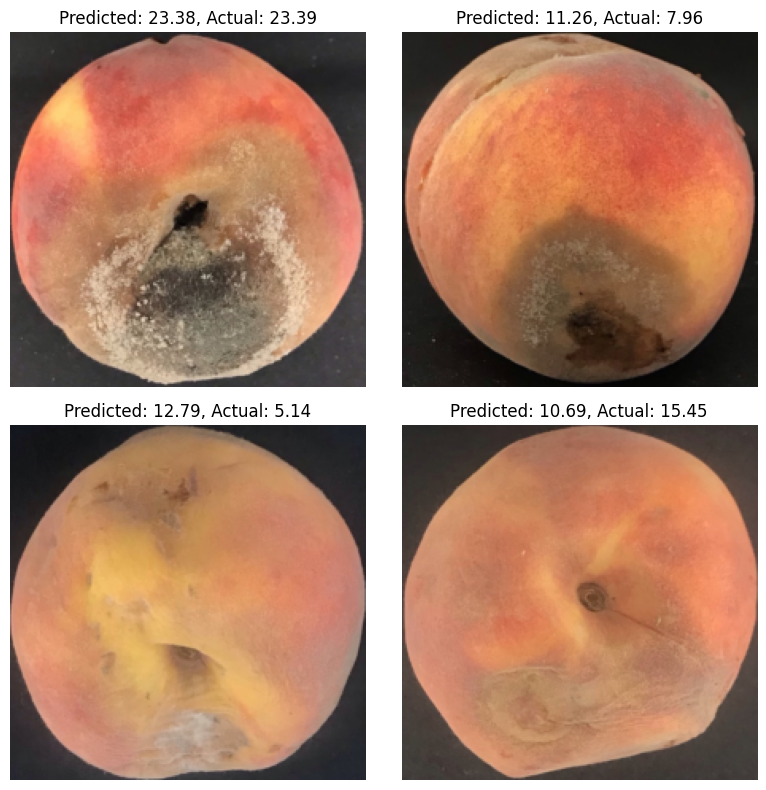

In [50]:
# Evaluation
model.eval()
with torch.no_grad():
    # Get random indices for 4 test images
    indices = np.random.choice(len(test_dataset), size=4, replace=False)

    # Create a subplot
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    for i, idx in enumerate(indices):
        inputs, label = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        output = model(inputs)
        prediction = output.item()

        # Denormalize the image
        img = inputs.squeeze().permute(1, 2, 0).cpu().numpy()

        # Display the image
        axs[i // 2, i % 2].imshow(img)
        axs[i // 2, i % 2].set_title(
            f"Predicted: {prediction:.2f}, Actual: {label:.2f}"
        )
        axs[i // 2, i % 2].axis("off")

    plt.tight_layout()
    plt.show()